# Expected Goals (xG) Model Analysis Notebook

This notebook outlines the process of building an Expected Goals (xG) model based on football match shot data. It covers the initial data loading, feature engineering (calculating shot distances and angles), model fitting, and analysis through visualizations to understand shot effectiveness.

In [1]:
# Importing libraries and loading the dataset
import pandas as pd
import numpy as np
import json
#Plotting
import matplotlib.pyplot as plt
import FCPython 
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
with open(r"C:\Users\santo\OneDrive\Wyscout\events_World_Cup.json") as f:
    data = json.load(f)

In [2]:
# Creating a DataFrame from the loaded data and filtering for shots
train = pd.DataFrame(data)
pd.unique(train['subEventName'])
shots=train[train['subEventName']=='Shot']
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

In [8]:
# Displaying the shape of the dataset to understand its size
train.shape

(101759, 12)

In [3]:
# Feature engineering: Calculating shot distance, angle, and whether it was a goal
for i,shot in shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

In [4]:
# Visualizing shot and goal distributions
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

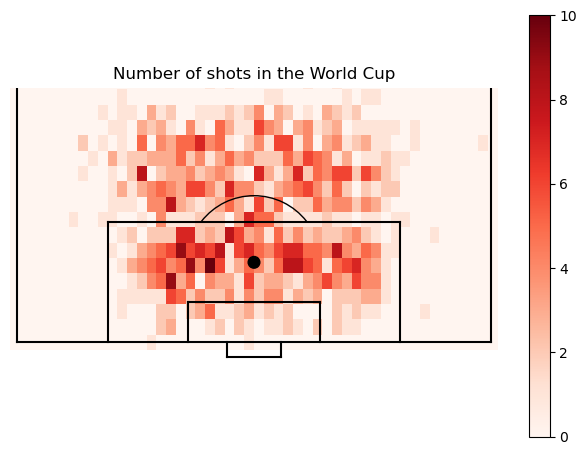

In [5]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots in the World Cup')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

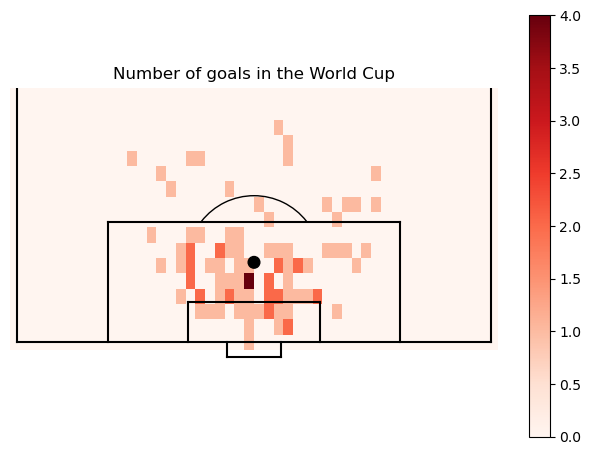

In [9]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals in the World Cup')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
  


C:\Users\santo\AppData\Local\Temp\ipykernel_12492\3449602281.py:2: RuntimeWarning: invalid value encountered in divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


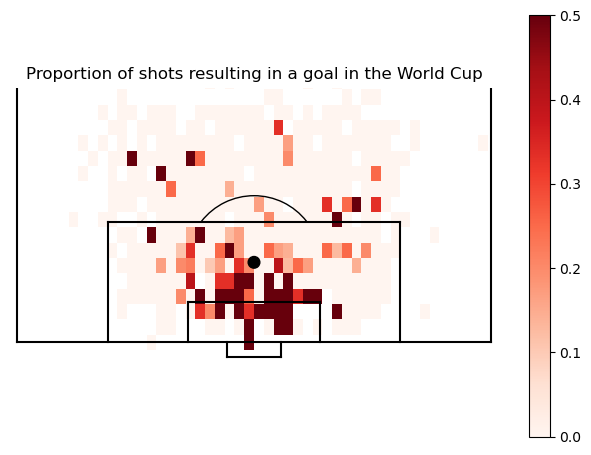

In [10]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal in the World Cup')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

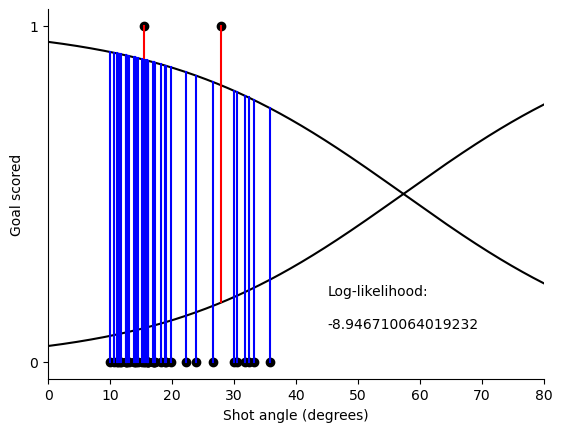

In [16]:
b=[3, -3]
x=np.arange(150,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

#Now lets look at the likelihood of model given data
xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
shots_model = shots_model.assign(xG=xG)
shots_40=shots_model.iloc[:40]
fig,ax=plt.subplots(num=1)
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang=shot['Angle']*180/np.pi
    if shot['Goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='blue')
    
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 1179
Model:                                GLM   Df Residuals:                     1177
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -279.76
Date:                    Thu, 29 Feb 2024   Deviance:                       559.51
Time:                            01:32:15   Pearson chi2:                 1.06e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08598
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

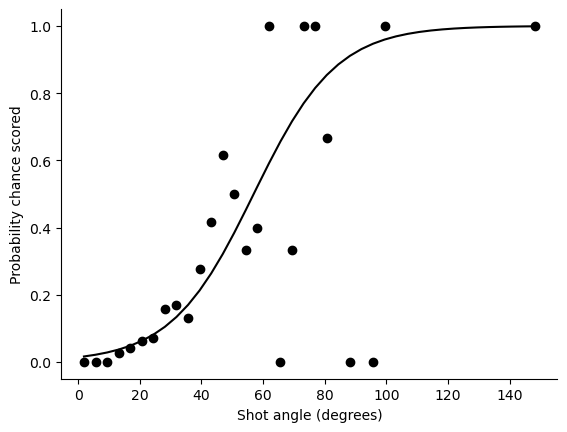

In [18]:
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params


xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

C:\Users\santo\AppData\Local\Temp\ipykernel_2096\488483413.py:4: RuntimeWarning: invalid value encountered in divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


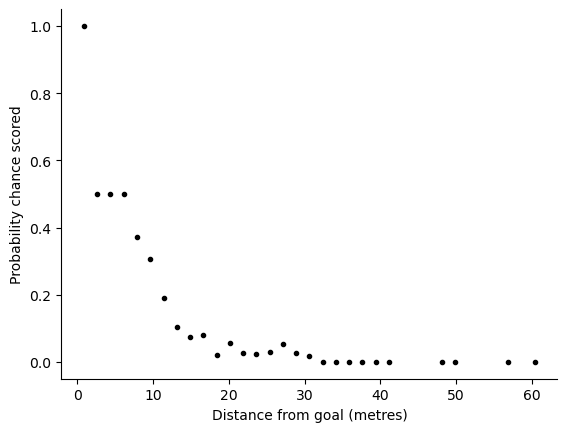

In [10]:
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [11]:
test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 1179
Model:                                GLM   Df Residuals:                     1177
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -278.58
Date:                    Thu, 29 Feb 2024   Deviance:                       557.17
Time:                            15:04:07   Pearson chi2:                 1.43e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08780
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 1179
Model:                                GLM   Df Residuals:                     1176
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -276.37
Date:                    Thu, 29 Feb 2024   Deviance:                       552.74
Time:                            01:34:14   Pearson chi2:                 1.32e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.09121
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

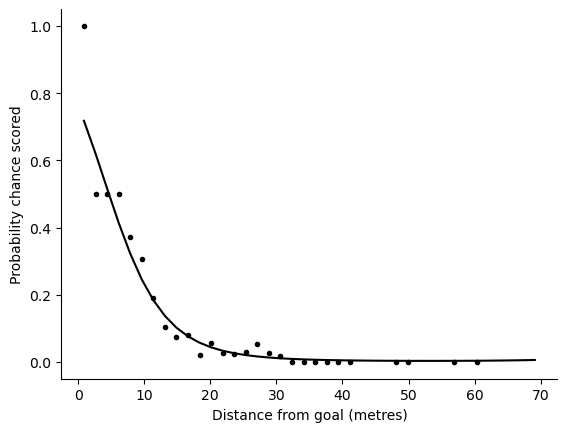

In [22]:
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

In [33]:
squaredX = shots_model['X']**2
shots_model = shots_model.assign(X2=squaredX)
squaredY = shots_model['Y']**2
shots_model = shots_model.assign(Y2=squaredY)
squaredC = shots_model['C']**2
shots_model = shots_model.assign(C2=squaredC)
AX = shots_model['Angle']*shots_model['X']
shots_model = shots_model.assign(AX=AX)
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)


In [37]:
model_variables = ['Angle','Distance','C','X']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]


#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 1179
Model:                                GLM   Df Residuals:                     1133
Model Family:                    Binomial   Df Model:                           45
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -257.03
Date:                    Thu, 29 Feb 2024   Deviance:                       514.06
Time:                            15:32:17   Pearson chi2:                     998.
No. Iterations:                        24   Pseudo R-squ. (CS):             0.1206
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

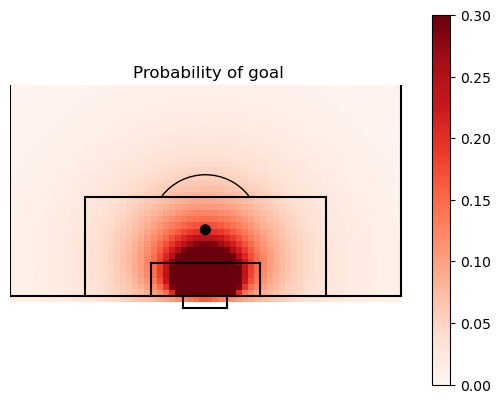

In [42]:
#Return xG value for more general model
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum)) 
   return xG   

#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)


#Create a 2D map of xG
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

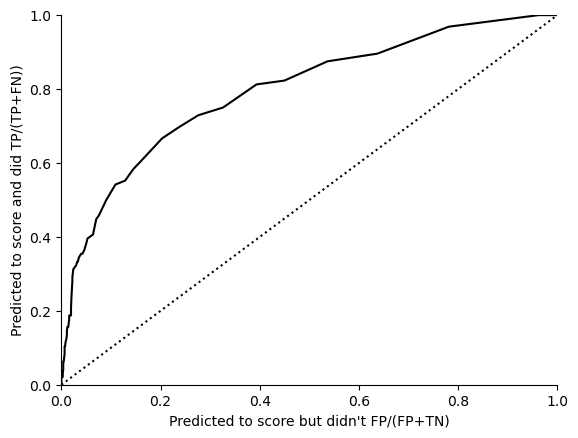

In [43]:
null_model = smf.glm(formula="Goal ~ 1 ", data=shots_model, 
                           family=sm.families.Binomial()).fit()
1-test_model.llf/null_model.llf

#ROC curve
numobs=100
TP=np.zeros(numobs)
FP=np.zeros(numobs)
TN=np.zeros(numobs)
FN=np.zeros(numobs)


for i,threshold in enumerate(np.arange(0,1,1/numobs)):
    for j,shot in shots_model.iterrows():
        if (shot['Goal']==1): 
            if(shot['xG']>threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal']==0): 
            if(shot['xG']>threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1
     

fig,ax=plt.subplots(num=1)
ax.plot(FP/(FP+TN), TP/(TP+FN), color='black')
ax.plot([0,1], [0,1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00,1.00))
plt.xlim((0.00,1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)           